<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary
The cells counter algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Install libraries. Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [67]:
!pip install czifile
!pip install tifffile
!pip install imagecodecs

Connect to Google disk.

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries.

In [69]:
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border
import czifile
import imagecodecs
#import tifffile

Check the settings.

In [70]:
#Image under study
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi'
pixels2microns = 0.396 #scale factor (check the image properties in Zen or Apeer)

#Visualisation
img_size = [0,0,512,512] # empty [] or rectangle coordinates, e.g. [0,0,512,512]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = (5,5)
ps = 5 # patch_size
pd = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 300

Download "czi" image and create slices of the image.

In [71]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]]

img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable 

channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
print('2 channels shape: ',img_slice.shape)
print('0 channel shape: ',img0.shape)
print('1 channel shape: ',img1.shape)

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
2 channels shape:  (2, 512, 512)
0 channel shape:  (512, 512)
1 channel shape:  (512, 512)


Filter image channels

In [85]:
#sigma_est = [0]*nc
#patch_kw = [0]*nc
for i in n:
  # denoise_nl_means performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=pd, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  channelsF[i] = np.uint16(channelsF[i])
  # Calculate a multidimensional median filter
  channelsF[i]= ndimage.median_filter(channelsF[i], size=kernel4filt[0])
  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
   

0 channel sigma estimation =  7.571724857322444
0 channel shape:  (512, 512) uint16 <class 'numpy.ndarray'>
1 channel sigma estimation =  364.77638780070606
1 channel shape:  (512, 512) uint16 <class 'numpy.ndarray'>


Visualize channels before and after filtering.

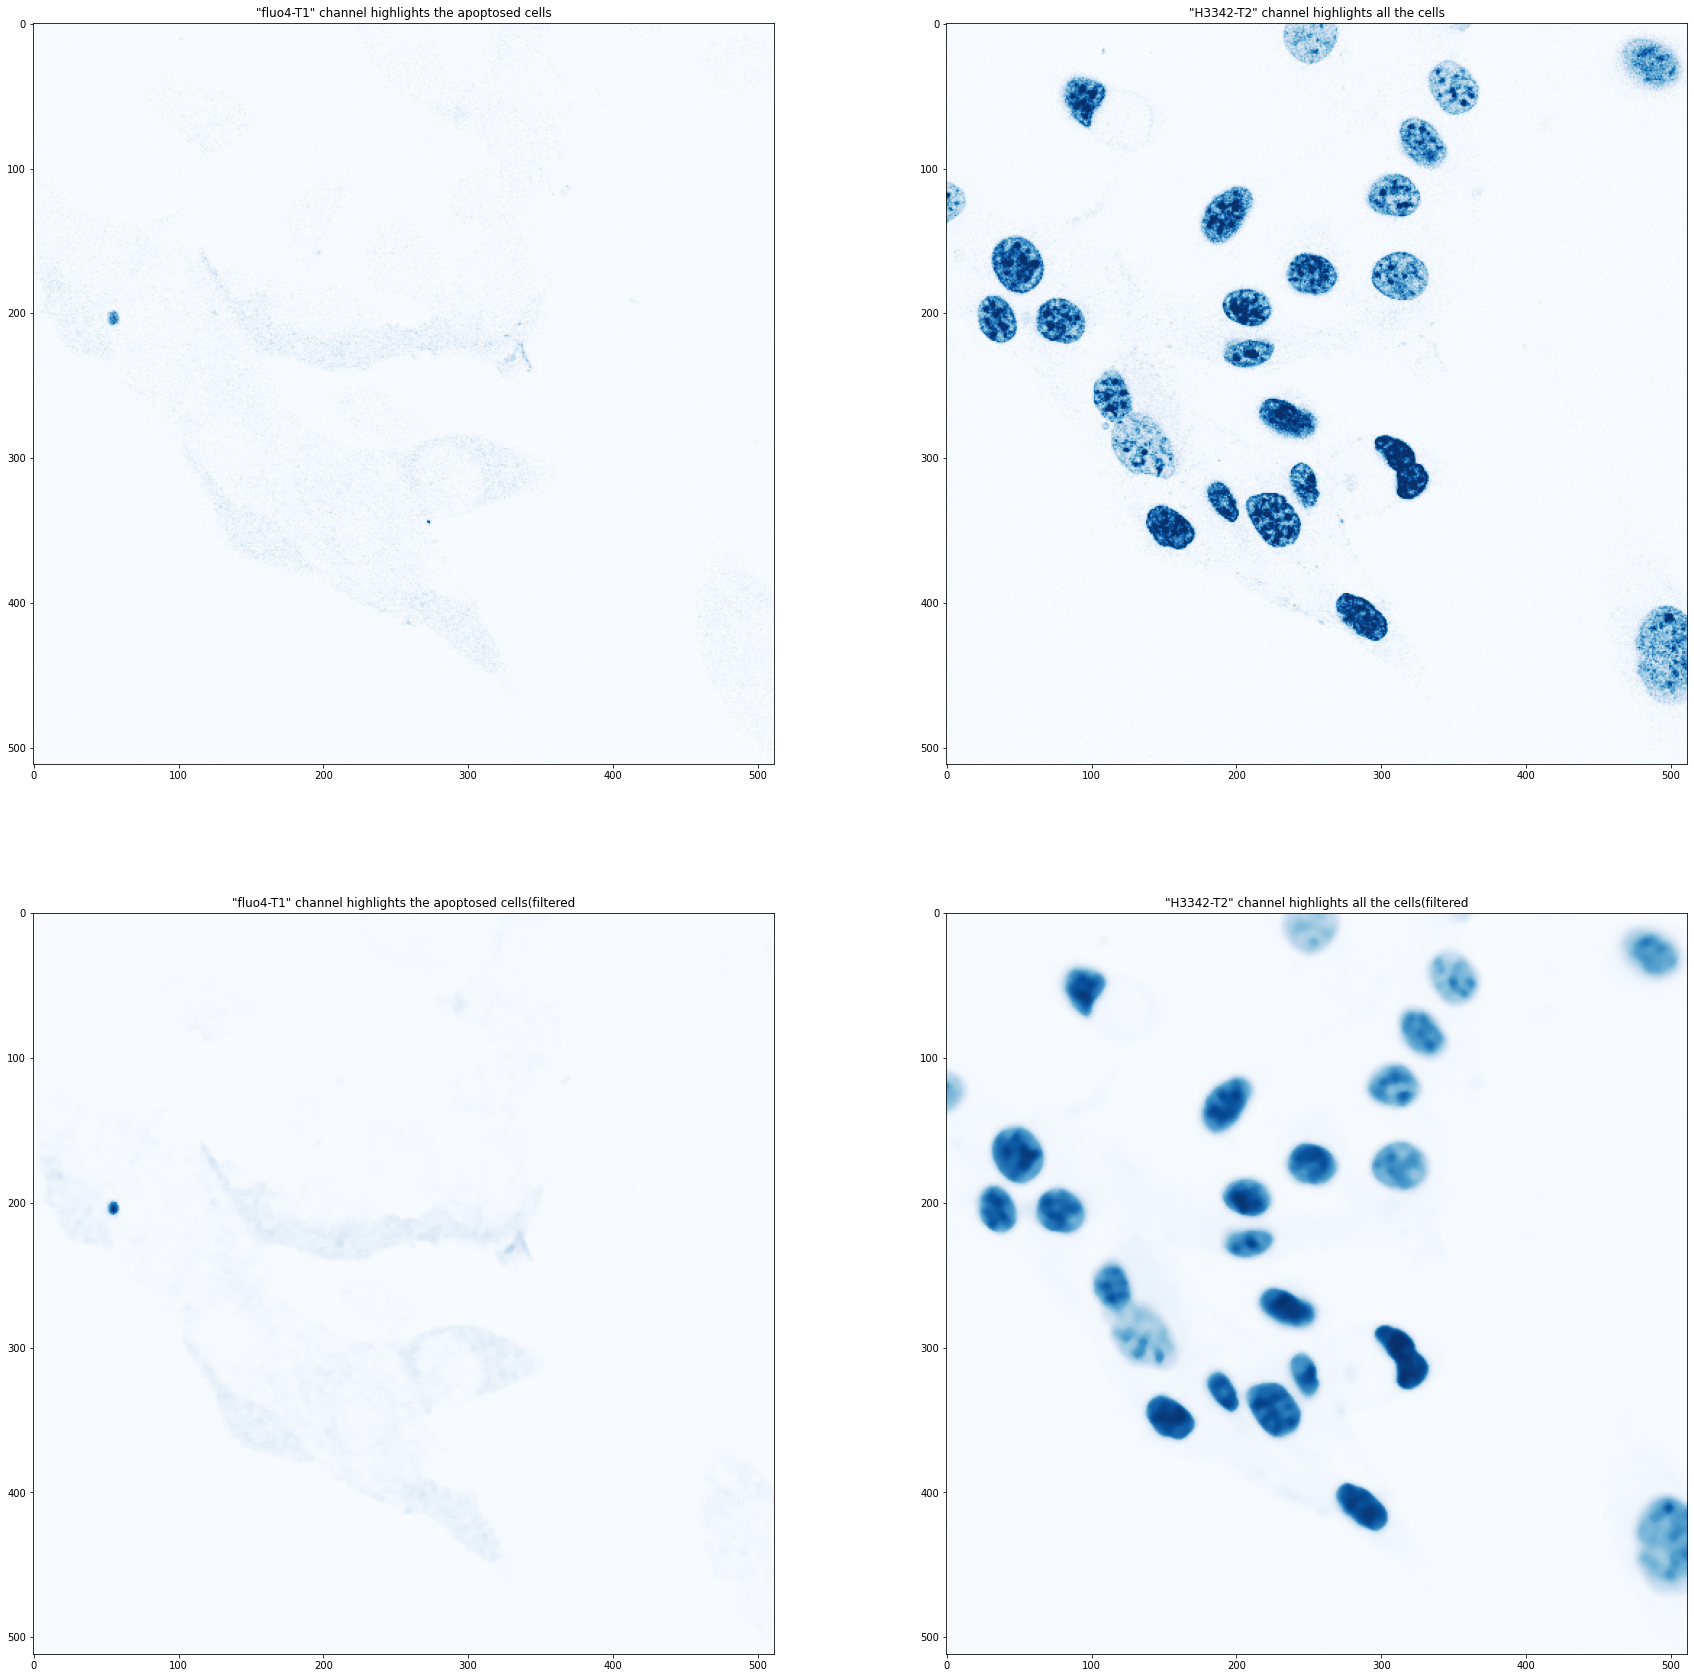

In [73]:
titles = ['"fluo4-T1" channel highlights the apoptosed cells',
          '"H3342-T2" channel highlights all the cells']
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])
  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+'(filtered')  

Create tepmorary files.

In [74]:
for i in n:
  img_path_temp[i] = img_path + img_title[0:-4] + '_ch' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channels[i]) # save channels in a temporary tiff file
print(img_path_temp)

['/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch0.tiff', '/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.tiff']


Read image using OpenCV.

In [75]:
for i in n:
  channelsGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsGray[i]),channelsGray[i].shape,channelsGray[i].dtype)

<class 'numpy.ndarray'> (512, 512) uint8
<class 'numpy.ndarray'> (512, 512) uint8


Threshold image to binary using OTSU. All the thresholded pixels are set to 255. Then remove noise (opening) and remove edge touching with clear_border function.

In [76]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsGray[i], 0, 255,
                                 cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  opening[i] = clear_border(opening[i])

Identify background and foreground area (OpenCV - Distance Transformation). Apply watershed.

In [77]:
unknown = [0]*nc
ret2 = [0]*nc
markers = [0]*nc
channelsFB = [0]*nc
channelsFW = [0]*nc
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground
  
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1

  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0]
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

Calculate metrics.

In [78]:
regions = [0]*nc
numberOfCells = [0]*nc

for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i]) 
  print(regions[i])
print('Number of cells is equal to',numberOfCells)

[<skimage.measure._regionprops.RegionProperties object at 0x7fd12afed4d0>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b0d9950>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b0d9410>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b0d9590>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b1367d0>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136e50>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136e10>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136fd0>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136310>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136e90>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b136c50>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b1369d0>, <skimage.measure._regionprops.RegionProperties object at 0x7fd12b1c8110>, <skimage.measure._regionprops.RegionP

Visualize boundaries and cells.

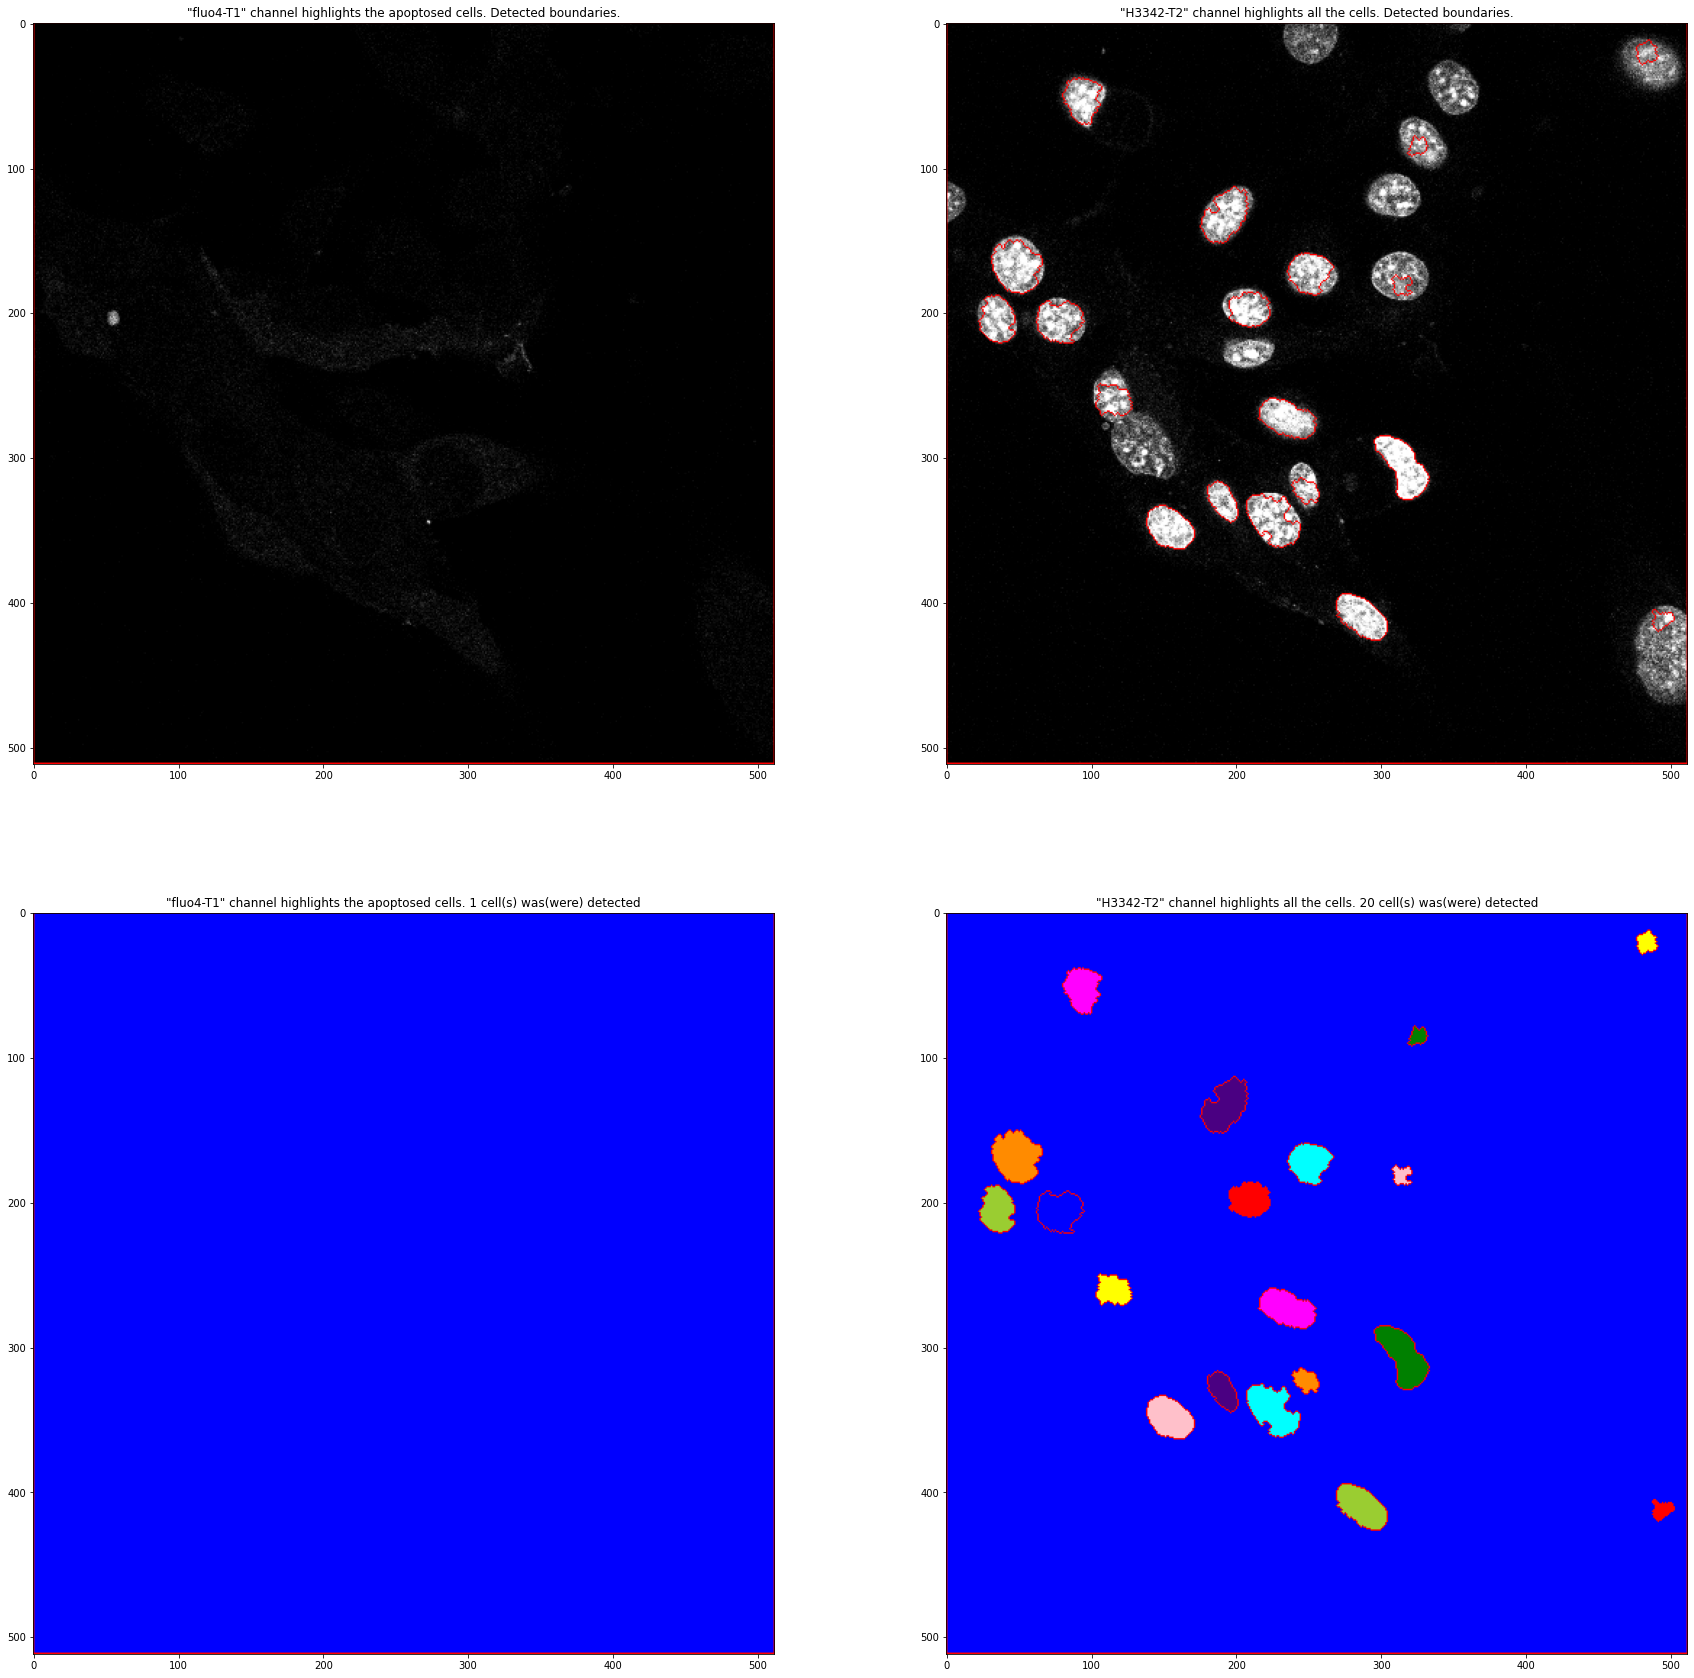

In [82]:
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cells were detected')

In [80]:
#print(propList)
#print(region_props)
#print(markers1)
#print(len(regions))